# A small 1D pic without Poisson
To try out the fake R model

In [32]:
#import
import numpy as np
import scipy as sp
import astropy
from imp import reload

import matplotlib.pyplot as plt
%matplotlib inline

import pic

from pic.plasma import plasma
from pic.particles import particles

from pic.functions import generate_maxw, velocity_maxw_flux, max_vect, fux_vect, numba_return_density, smooth
from pic.constantes import (me, q,kb,eps_0,mi)

reload(pic)
reload(pic.plasma)
reload(pic.particles)
reload(pic.functions)
reload(pic.constantes)

from ipywidgets import IntProgress as prog
from IPython.display import display
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [34]:
#parameters
Lx = 1e-2 #System length
dX = 1e-5 #dX in m
Nx = int(Lx/dX)+1 #cell number
Lx = Nx*dX
print("Nx = {Nx}, and Lx = {Lx} cm".format(Nx = Nx, Lx = Lx*100))

Npart = 50*Nx #particles number, in particle par cell
n = 3e17  #[m^-3]
dT = 4e-12 #time step
Te_0 = 30;     #[eV] Electron distribution temperature
Ti_0 = 5 #[eV]

L_De = np.sqrt(eps_0*Te_0/(q*n))
wpe = np.sqrt(n*q**2/(eps_0*me))

print(f"L_de = {L_De*1e3:2.2f} mm, dX = {dX*1e3} mm")
print(f"time step dT = {dT*1e12:2.4f} mu s, wpe = {wpe**(-1)*1e12:2.2f} mus")
print(wpe)

Nx = 1000, and Lx = 1.0 cm
L_de = 0.07 mm, dX = 0.01 mm
time step dT = 4.0000 mu s, wpe = 32.36 mus
30898995097.852306


In [35]:
pla = plasma(dT,Nx,Lx,Npart,n,Te_0,Ti_0)
print(len(pla.ele.x),len(pla.ion.x))

~~~~~~ Initialisation of Plasma simulation ~~~~~~~~~~
time step dT = 4.00 10^-12 s, wpe = 32.36 10^-12 s
mesh step dX = 10.00 mu m, LDe = 74.34
 Let's go !!
50000 50000


In [132]:
#%%snakeviz

Nt = 200

for nt in np.arange(Nt):
    if nt%10 == 0 : print("\r t = {:2.4f} over {:2.4f} mu s".format(nt*pla.dT*1e6,Nt*pla.dT*1e6),end="")
    pla.pusher()
    pla.boundary()
    pla.compute_rho()
    pla.solve_poisson()
    #print(len(pla.ele.x),len(pla.ion.x))
    


 t = 0.0190 over 0.0200 mu s

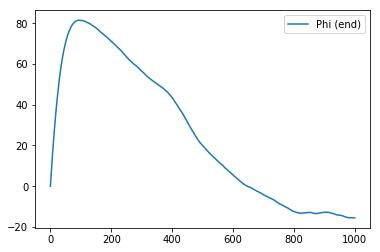

In [43]:
plt.plot((pla.phi),label = "Phi (end)");

plt.legend()

2.8305000000000005e+18 2.9933400000000005e+18


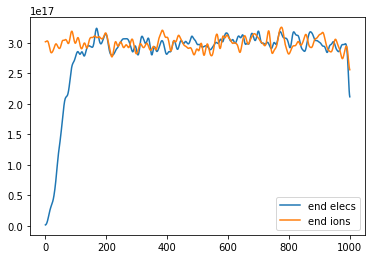

In [42]:
plt.plot(smooth(pla.ne),label = "end elecs");
plt.plot(smooth(pla.ni),label = "end ions");
plt.legend()
print(pla.ne.sum()*Lx,pla.ni.sum()*Lx)

~~~~~~ Initialisation of Plasma simulation ~~~~~~~~~~
time step dT = 4.00 10^-12 s, wpe = 32.36 10^-12 s
mesh step dX = 10.00 mu m, LDe = 74.34
 Let's go !!


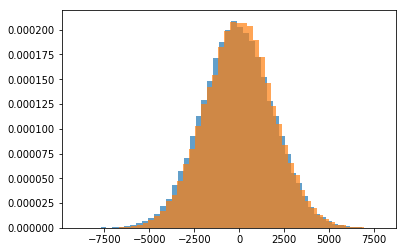

In [41]:
plt.hist(pla.ion.V[:,0],bins=50, alpha = 0.7,density=True);
plainit = plasma(dT,Nx,Lx,Npart,n,Te_0,Ti_0)
plt.hist(plainit.ion.V[:,0],bins=50, alpha = 0.7,density=True);



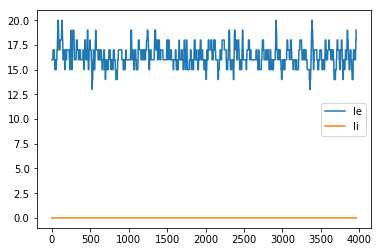

In [40]:
plt.plot(smooth(pla.history["Ie_c"][40:]), label = "Ie")
plt.plot(smooth(pla.history["Ii_c"][40:]), label = "Ii")
plt.legend()

In [44]:
ne = pla.ne.copy()
phi = pla.phi.copy()
Te,ve = np.zeros((2,Nx))
Nt = 4000
Do_diags = False
for nt in np.arange(Nt):
    if nt%10 == 0 : print("\r t = {:2.4f} over {:2.4f} mu s".format(nt*pla.dT*1e6,Nt*pla.dT*1e6),end="")
    pla.pusher()
    pla.boundary()
    pla.compute_rho()
    pla.solve_poisson()
    
    if Do_diags:
        parts = pla.ele
        for i in np.arange(Nx):
            V = parts.V[(parts.x > pla.x_j[i]) & (parts.x < pla.x_j[i]+pla.dx),0]
            if len(V) > 0:
                ve[i] += np.mean(V)
                Te[i] += np.std(V)**2*me/q
            else:
                ve[i] += 0
                Te[i] += 0

        ne += pla.ne.copy()
        phi += pla.phi.copy()
    
ne /= (Nt + 1)
phi /= (Nt + 1)
Te /= Nt
ve /= Nt

 t = 0.0160 over 0.0160 mu s

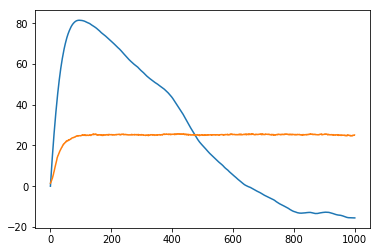

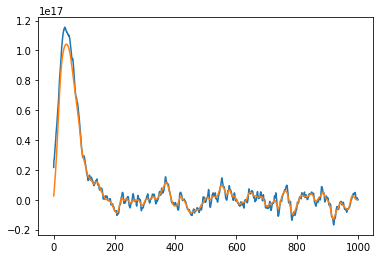

In [37]:
nT = smooth((ne[:-1]*Te)[:-1])
plt.plot(pla.phi)
plt.plot(Te)
plt.show()
plt.plot(ne*np.gradient(phi))
plt.plot(np.gradient(nT))


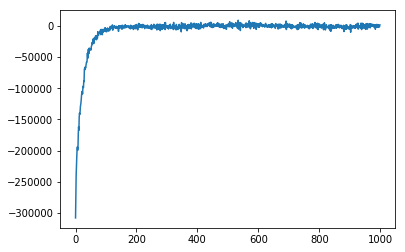

In [38]:
plt.plot(ve)

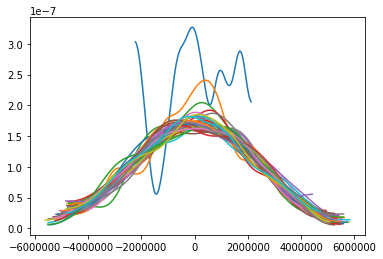

In [39]:
parts = pla.ele
Nc = 20
for i in np.arange(int(Nx/Nc)):
    j = Nc*i

    mask = (parts.x > pla.x_j[j]) & (parts.x < (pla.x_j[j]+Nc*pla.dx))
    V = parts.V[mask,0]
    hist, bin_edges = np.histogram(V, density= True, bins = 100)
    plt.plot(bin_edges[0:-1],smooth(hist))

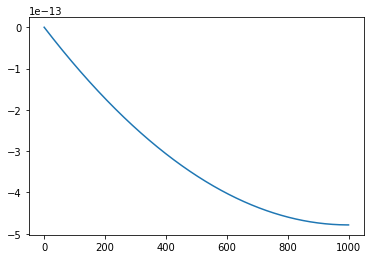

In [17]:
#Generate plasma
pla2 = plasma(dT,Nx,Lx,Npart,n,Te,Ti)

#fix Electric field profile
#pla.E[:,0] = 45e3*np.exp(-pla.x_j/(5*L_De))
pla.compute_rho()
pla.rho = -np.ones(Nx+1)*1e-18

pla.solve_poisson()
plt.plot(pla.phi)
plt.show()


In [ ]:
plt.hist(pla.ele.V[:,0],label="end",bins=100);
plt.legend()

In [ ]:
pla.compute_rho()
pla.solve_poisson()
print(pla.rho)

In [ ]:
di = pla.rho.copy() / 555
diprim = di.copy()
print(diprim)

In [ ]:
plt.plot(pla.E[:,0])
plt.show()
plt.plot(pla.phi)

In [ ]:
print(diprim)
print(pla.bi)
pla.ai[0] = 0.
print(pla.ai)
print(pla.ci)
ciprim = np.copy(pla.ci) #copy the value, not the reference
ciprim[0] /= pla.bi[0]
for i in np.arange(1,len(ciprim)):
    ciprim[i] /= pla.bi[i] - pla.ai[i]*ciprim[i-1]

pla.ciprim = ciprim
print(pla.ciprim)

In [ ]:
diprim = np.copy(pla.rho)

diprim[0] /= pla.bi[0]
for i in np.arange(1,len(diprim)):
    if pla.ai[i] < 0.5 : print(i)
    diprim[i] -= pla.ai[i]*diprim[i-1]
    diprim[i] /= pla.bi[i] - pla.ai[i]*pla.ciprim[i-1]
    
print(diprim)
pla.phi[0] = 0
pla.phi[-1] = diprim[-1]
#limit conditions
pla.rho[[0,-1]] = 0
for i in np.arange(pla.Nx-1,1,-1):
    pla.phi[i] = diprim[i] - pla.ciprim[i]*pla.phi[i+1]

In [ ]:
plt.plot(pla.phi)

In [ ]:
diprim.copy()